In [19]:
import numpy as np
import pandas as pd

from time import process_time
import time

import datetime 
import arrow

import sys
import os
import re 
import math

import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams["axes.unicode_minus"]=False #用來正常顯示負號

from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname="C:/Users/s0970/python/113碩二上讀書會/吳蒨芸/TaipeiSansTCBeta-Regular.ttf")

import seaborn as sns
sns.set(font="Microsoft JhengHei") #正常顯示中文

In [3]:
from nltk.tokenize import RegexpTokenizer #正則化斷詞
from nltk.tokenize import word_tokenize #斷詞

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

In [4]:
iceland = pd.read_csv("iceland_real.csv",index_col=0)
greece = pd.read_csv("greece_real.csv",index_col=0)

In [5]:
iceland.sentiment.value_counts()

0    73344
1     2252
Name: sentiment, dtype: int64

In [6]:
73344/2252

32.56838365896981

# 冰島

In [54]:
iceland["reviews_clear"] = iceland["reviews_clear"].apply(lambda x : np.str(x))

In [55]:
#initial

token_re = RegexpTokenizer(r'[a-zA-Z0-9]+')

weight = [(i+1)*10 for i in range(10)]

model_type = {"rf":1,"svm":2,"gb":3}

word2v_type ={"cbow":0,"skip":1}

### Bag of Words 

In [9]:
def Bag_of_word(data,type,measure,rd,we=None,lr=None):
    
    cv = CountVectorizer(lowercase=True,max_features=1000,stop_words='english',ngram_range = (1,2),tokenizer = token_re.tokenize)
    text_cv = cv.fit_transform(data.reviews_clear)

    X_train, X_test, y_train, y_test = train_test_split(text_cv, data['sentiment'], test_size=0.2, random_state=rd)

    tp = model_type[type]

    if tp == 1:
        rf = RandomForestClassifier(n_estimators = 100,class_weight = {0:1,1:we},random_state =rd)
        rf.fit(X_train, y_train)
        
        predicted= rf.predict(X_test)
        prob = rf.predict_proba(X_test)


    elif tp == 2:
        sv = SVC(kernel="rbf",class_weight = {0:1,1:we},random_state =rd,probability=True)
        sv.fit(X_train, y_train)

        predicted= sv.predict(X_test)
        prob = sv.predict_proba(X_test)


    elif tp == 3:
        gb = GradientBoostingClassifier(learning_rate=lr,max_depth=5, n_estimators = 1000,random_state =rd)
        gb.fit(X_train, y_train)

        predicted= gb.predict(X_test)
        prob = gb.predict_proba(X_test)



    if measure=="recall":
        return metrics.recall_score(y_test, predicted)

    elif measure=="f1_score":
        return metrics.f1_score(y_test, predicted)

    elif measure=="auc_score":
        prob = prob [:,1]
        fpr, tpr, thresholds_keras = metrics.roc_curve(np.array(y_test), prob)
        return metrics.auc(fpr, tpr)

    elif measure=="roc":
        prob = prob [:,1]
        return metrics.roc_curve(np.array(y_test), prob)
        


In [71]:
recall_bow_rf = []
for i in weight :
    recall_bow_rf.append(Bag_of_word(iceland,"rf","recall",10,we=i))

recall_bow_rf

[0.026970954356846474,
 0.024896265560165973,
 0.029045643153526972,
 0.03112033195020747,
 0.026970954356846474,
 0.03319502074688797,
 0.03319502074688797,
 0.03112033195020747,
 0.03941908713692946,
 0.03941908713692946]

In [60]:
f1_bow_rf = []
for i in weight :
    f1_bow_rf.append(Bag_of_word(iceland,"rf","f1_score",10,we=i))

f1_bow_rf

[0.049618320610687015,
 0.04436229205175601,
 0.05137614678899082,
 0.054644808743169404,
 0.04735883424408014,
 0.05839416058394161,
 0.05850091407678245,
 0.054945054945054944,
 0.05507246376811595,
 0.05467625899280576]

In [13]:
recall_bow_svm = []
for i in weight :
    recall_bow_svm.append(Bag_of_word(iceland,"svm","recall",10,we=i))

recall_bow_svm

[0.21784232365145229,
 0.26348547717842324,
 0.27385892116182575,
 0.27800829875518673,
 0.2883817427385892,
 0.2863070539419087,
 0.29045643153526973,
 0.2883817427385892,
 0.2821576763485477,
 0.2863070539419087]

In [16]:
f1_bow_svm = []
for i in weight :
    f1_bow_svm.append(Bag_of_word(iceland,"svm","f1_score",10,we=i))

f1_bow_svm

[0.2755905511811024,
 0.28475336322869954,
 0.2755741127348643,
 0.27098078867542974,
 0.2670509125840538,
 0.2562674094707521,
 0.25408348457350277,
 0.247992863514719,
 0.2379702537182852,
 0.23731728288907997]

In [73]:
recall_bow_gb = Bag_of_word(iceland,"gb","recall",10,lr=0.1)
recall_bow_gb

0.18672199170124482

In [17]:
f1_bow_gb = Bag_of_word(iceland,"gb","f1_score",10,lr=0.1)
f1_bow_gb

0.2731411229135053

### TF-IDF

In [10]:
def tf_idf(data,type,measure,rd,we=None,lr=None):

    tf = TfidfVectorizer(stop_words='english',max_features=1000,ngram_range = (1,2),tokenizer = token_re.tokenize,smooth_idf=True, norm='l2')
    text_tf = tf.fit_transform(data.reviews_clear)

    X_train, X_test, y_train, y_test = train_test_split(text_tf, data['sentiment'], test_size=0.2, random_state=rd)
    
    tp = model_type[type]

    if tp == 1:
        rf = RandomForestClassifier(n_estimators = 100,class_weight = {0:1,1:we},random_state =rd)
        rf.fit(X_train, y_train)
    
        predicted= rf.predict(X_test)
        prob = rf.predict_proba(X_test)


    elif tp == 2:
        sv = SVC(kernel="rbf",class_weight = {0:1,1:we},random_state =rd,probability=True)
        sv.fit(X_train, y_train)

        predicted= sv.predict(X_test)
        prob = sv.predict_proba(X_test)



    elif tp == 3:
        gb = GradientBoostingClassifier(learning_rate=lr,max_depth=5, n_estimators = 1000,random_state =rd)
        gb.fit(X_train, y_train)

        predicted= gb.predict(X_test)
        prob = gb.predict_proba(X_test)

    
    
    if measure=="recall":
        return metrics.recall_score(y_test, predicted)

    elif measure=="f1_score":
        return metrics.f1_score(y_test, predicted)

    elif measure=="auc_score":
        prob = prob [:,1]
        fpr, tpr, thresholds_keras = metrics.roc_curve(np.array(y_test), prob)
        return metrics.auc(fpr, tpr)

    elif measure=="roc":
        prob = prob [:,1]
        return metrics.roc_curve(np.array(y_test), prob)
    
        


In [75]:
recall_tf_rf = []
for i in weight :
    recall_tf_rf.append(tf_idf(iceland,"rf","recall",10,we=i))

recall_tf_rf

[0.016597510373443983,
 0.029045643153526972,
 0.026970954356846474,
 0.026970954356846474,
 0.03319502074688797,
 0.03319502074688797,
 0.03734439834024896,
 0.03319502074688797,
 0.043568464730290454,
 0.03734439834024896]

In [21]:
f1_tf_rf = []
for i in weight :
    f1_tf_rf.append(tf_idf(iceland,"rf","f1_score",10,we=i))

f1_tf_rf

[0.03143418467583497,
 0.05333333333333333,
 0.04905660377358491,
 0.04914933837429111,
 0.05981308411214954,
 0.0599250936329588,
 0.06642066420664207,
 0.05904059040590406,
 0.06086956521739131,
 0.05240174672489082]

In [76]:
recall_tf_svm = []
for i in weight :
    recall_tf_svm.append(tf_idf(iceland,"svm","recall",10,we=i))

recall_tf_svm

[0.1887966804979253,
 0.1887966804979253,
 0.1887966804979253,
 0.1887966804979253,
 0.1887966804979253,
 0.1887966804979253,
 0.1887966804979253,
 0.1908713692946058,
 0.1908713692946058,
 0.1908713692946058]

In [22]:
f1_tf_svm = []
for i in weight :
    f1_tf_svm.append(tf_idf(iceland,"svm","f1_score",10,we=i))

f1_tf_svm

[0.2778625954198473,
 0.2765957446808511,
 0.27617602427921095,
 0.27617602427921095,
 0.27123695976154993,
 0.27123695976154993,
 0.27123695976154993,
 0.2280049566294919,
 0.2280049566294919,
 0.22330097087378642]

In [77]:
recall_tf_gb = tf_idf(iceland,"gb","recall",10,lr=0.1)
recall_tf_gb

0.14522821576763487

In [23]:
f1_tf_gb = tf_idf(iceland,"gb","f1_score",10,lr=0.1)
f1_tf_gb 

0.2147239263803681

### Word2Vec

In [101]:
word2v = iceland.translate_reviews.apply(word_tokenize)
word2v = word2v.apply(lambda x : [i.lower() for i in x])

In [57]:
model_cbow = Word2Vec(word2v,
                      min_count=5,
                      vector_size=1000,
                      workers=10,
                      epochs=100,
                      window=5,
                      sg=0, # CBOW
                      seed=10,
                      batch_words=500)

model_skip = Word2Vec(word2v,
                      min_count=5,
                      vector_size=1000,
                      workers=10,
                      epochs=100,
                      window=5,
                      sg=1, # Skip-gram
                      seed=10,
                      batch_words=500)

def average_vector(review,type):
    
    tp = word2v_type[type]

    if tp == 0:
        
        array=np.array([model_cbow.wv[w] for w in review if w in model_cbow.wv])
    
        return pd.Series(array.mean(axis=0)) 

    elif tp == 1:
        
        array=np.array([model_skip.wv[w] for w in review if w in model_skip.wv])
    
        return pd.Series(array.mean(axis=0)) 


In [103]:
model_cbow = Word2Vec.load('cbow_iceland.model')
model_skip = Word2Vec.load('skip_iceland.model')

In [104]:
def average_vector(review,type):
    
    tp = word2v_type[type]

    if tp == 0:
        
        array=np.array([model_cbow.wv[w] for w in review if w in model_cbow.wv])
    
        return pd.Series(array.mean(axis=0)) 

    elif tp == 1:
        
        array=np.array([model_skip.wv[w] for w in review if w in model_skip.wv])
    
        return pd.Series(array.mean(axis=0)) 

In [105]:
av_word_c = word2v.apply(lambda x :average_vector(x,"cbow"))
c_word = av_word_c.dropna(axis=0,how="any")
c_y = iceland["sentiment"][c_word.index]

av_word_s = word2v.apply(lambda x :average_vector(x,"skip"))
s_word = av_word_s.dropna(axis=0,how="any")
s_y = iceland["sentiment"][s_word.index]

<ipython-input-104-429d079aa04c>:9: RuntimeWarning: Mean of empty slice.
  return pd.Series(array.mean(axis=0))
<ipython-input-104-429d079aa04c>:15: RuntimeWarning: Mean of empty slice.
  return pd.Series(array.mean(axis=0))


In [106]:
def w2v(type,WORD,Y,measure,rd,we=None,lr=None):

    X_train, X_test, y_train, y_test = train_test_split(WORD , Y, test_size=0.2, random_state=rd)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    tp = model_type[type]

    if tp == 1:
        rf = RandomForestClassifier(n_estimators = 100,class_weight = {0:1,1:we},random_state =rd)
        rf.fit(X_train, y_train)

        predicted= rf.predict(X_test)
        prob = rf.predict_proba(X_test)

    elif tp == 2:
        sv = SVC(kernel="rbf",class_weight = {0:1,1:we},random_state =rd,probability=True)
        sv.fit(X_train, y_train)

        predicted= sv.predict(X_test)
        prob = sv.predict_proba(X_test)

    elif tp == 3:
        gb = GradientBoostingClassifier(learning_rate=lr,max_depth=5, n_estimators = 1000,random_state =rd)
        gb.fit(X_train, y_train)

        predicted= gb.predict(X_test)
        prob = gb.predict_proba(X_test)



    if measure=="recall":
        return metrics.recall_score(y_test, predicted)

    elif measure=="f1_score":
        return metrics.f1_score(y_test, predicted)

    elif measure=="auc_score":
        prob = prob [:,1]
        fpr, tpr, thresholds_keras = metrics.roc_curve(np.array(y_test), prob)
        return metrics.auc(fpr, tpr)

    elif measure=="roc":
        prob = prob [:,1]
        return metrics.roc_curve(np.array(y_test), prob)
    

In [22]:
model_cbow.save("cbow_iceland.model")

In [25]:
model_skip.save("skip_iceland.model")

In [23]:
recall_w2v_cbow_rf = []
for i in weight :
    recall_w2v_cbow_rf.append(w2v("rf",c_word,c_y,"recall",10,we=i))

recall_w2v_cbow_rf

[0.028446389496717725,
 0.04157549234135667,
 0.04814004376367615,
 0.05689277899343545,
 0.05470459518599562,
 0.05689277899343545,
 0.061269146608315096,
 0.05908096280087528,
 0.06345733041575492,
 0.06564551422319474]

In [28]:
f1_w2v_cbow_rf = []
for i in weight :
    f1_w2v_cbow_rf.append(w2v("rf",c_word,c_y,"f1_score",10,we=i))

f1_w2v_cbow_rf

[0.04583333333333334,
 0.08097165991902834,
 0.07920792079207921,
 0.1003861003861004,
 0.11068702290076336,
 0.10769230769230768,
 0.10305343511450382,
 0.11787072243346008,
 0.11385199240986715,
 0.11985018726591759]

In [24]:
recall_w2v_cbow_svm = []
for i in weight :
    recall_w2v_cbow_svm.append(w2v("svm",c_word,c_y,"recall",10,we=i))

recall_w2v_cbow_svm

[0.6433260393873085,
 0.6783369803063457,
 0.6761487964989059,
 0.6783369803063457,
 0.6783369803063457,
 0.6783369803063457,
 0.6783369803063457,
 0.6783369803063457,
 0.6783369803063457,
 0.6783369803063457]

In [29]:
f1_w2v_cbow_svm = []
for i in weight :
    f1_w2v_cbow_svm.append(w2v("svm",c_word,c_y,"f1_score",10,we=i))

f1_w2v_cbow_svm

[0.42608695652173906,
 0.3912201420271143,
 0.37670384138785623,
 0.3778461538461539,
 0.37629810629199756,
 0.3733333333333333,
 0.37378640776699035,
 0.37288135593220334,
 0.37288135593220334,
 0.37288135593220334]

In [18]:
recall_w2v_cbow_gb = w2v("gb",c_word,c_y,"recall",10,lr=0.1)
recall_w2v_cbow_gb

In [20]:
recall_w2v_cbow_gb

0.13785557986870897

In [21]:
f1_w2v_cbow_gb = w2v("gb",c_word,c_y,"f1_score",10,lr=0.1)
f1_w2v_cbow_gb

0.22743682310469313

In [12]:
recall_w2v_skip_rf = []
for i in weight :
    recall_w2v_skip_rf.append(w2v("rf",s_word,s_y,"recall",10,we=i))

recall_w2v_skip_rf

[0.0087527352297593,
 0.019693654266958426,
 0.030634573304157548,
 0.030634573304157548,
 0.03938730853391685,
 0.03282275711159737,
 0.037199124726477024,
 0.037199124726477024,
 0.037199124726477024,
 0.04157549234135667]

In [30]:
f1_w2v_skip_rf = []
for i in weight :
    f1_w2v_skip_rf.append(w2v("rf",s_word,s_y,"f1_score",10,we=i))

f1_w2v_skip_rf

[0.021459227467811162,
 0.04592901878914406,
 0.049999999999999996,
 0.05785123966942149,
 0.05761316872427983,
 0.07317073170731708,
 0.06557377049180327,
 0.06882591093117409,
 0.07214428857715431,
 0.06097560975609755]

In [13]:
recall_w2v_skip_svm = []
for i in weight :
    recall_w2v_skip_svm.append(w2v("svm",s_word,s_y,"recall",10,we=i))

recall_w2v_skip_svm

[0.687089715536105,
 0.7330415754923414,
 0.737417943107221,
 0.737417943107221,
 0.7330415754923414,
 0.7352297592997812,
 0.7396061269146609,
 0.7396061269146609,
 0.7396061269146609,
 0.7396061269146609]

In [31]:
f1_w2v_skip_svm = []
for i in weight :
    f1_w2v_skip_svm.append(w2v("svm",s_word,s_y,"f1_score",10,we=i))

f1_w2v_skip_svm

[0.4363636363636364,
 0.403680981595092,
 0.3903301886792453,
 0.3911266783420899,
 0.38847262247838615,
 0.38594470046082946,
 0.3882825962090753,
 0.38739255014326646,
 0.38717067583046966,
 0.38717067583046966]

In [15]:
recall_w2v_skip_gb = w2v("gb",s_word,s_y,"recall",10,lr=0.1)
recall_w2v_skip_gb 

0.13347921225382933

In [16]:
f1_w2v_skip_gb = w2v("gb",s_word,s_y,"f1_score",10,lr=0.1)
f1_w2v_skip_gb

0.21981981981981985

### 結果儲存

In [20]:
answer = pd.DataFrame({"BOW vs RF":recall_bow_rf,
                       "BOW vs SVM":recall_bow_svm,
                       "TFIDF vs RF":recall_tf_rf,
                       "TFIDF vs SVM":recall_tf_svm,
                       "W2v(CBOW) vs RF":recall_w2v_cbow_rf,
                       "W2v(CBOW) vs SVM":recall_w2v_cbow_svm,
                       "W2v(SKIP) vs RF":recall_w2v_skip_rf,
                       "W2v(SKIP) vs SVM":recall_w2v_skip_svm})

answer.index = [weight]

answer.to_csv("iceland_result.csv")

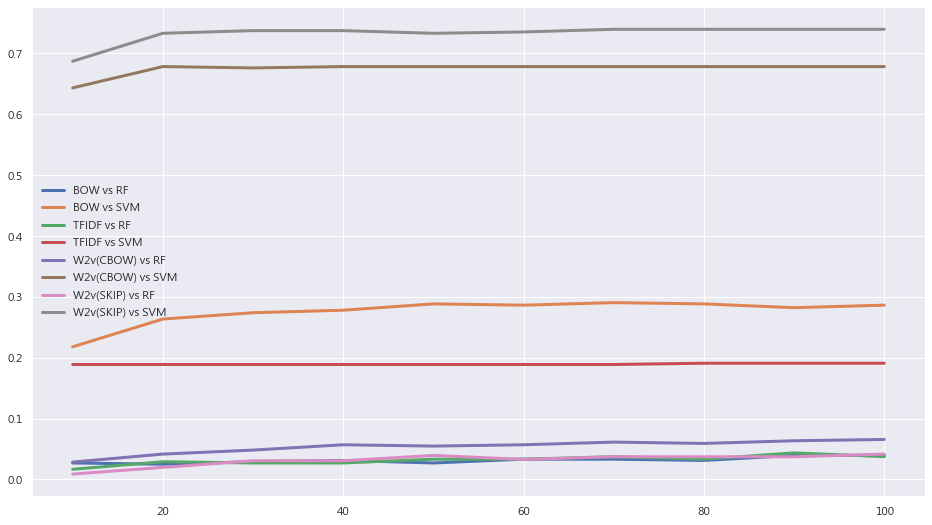

In [22]:
answer = pd.read_csv("greece_result.csv",index_col=0)
plt.figure(figsize=(16,9))

for i in range(len(answer.columns)):
    plt.plot(weight,answer.iloc[:,i],label="{}".format(answer.columns[i]),lw=3)

plt.rc('legend', fontsize=15)
plt.legend(loc=1,bbox_to_anchor=(1,0.93))
plt.show()

In [61]:
answer1 = pd.DataFrame({"BOW vs RF":f1_bow_rf,
                       "BOW vs SVM":f1_bow_svm,
                       "TFIDF vs RF":f1_tf_rf,
                       "TFIDF vs SVM":f1_tf_svm,
                       "W2v(CBOW) vs RF":f1_w2v_cbow_rf,
                       "W2v(CBOW) vs SVM":f1_w2v_cbow_svm,
                       "W2v(SKIP) vs RF":f1_w2v_skip_rf,
                       "W2v(SKIP) vs SVM":f1_w2v_skip_svm})

answer1.index = [weight]

answer1.to_csv("iceland_result_f1.csv")

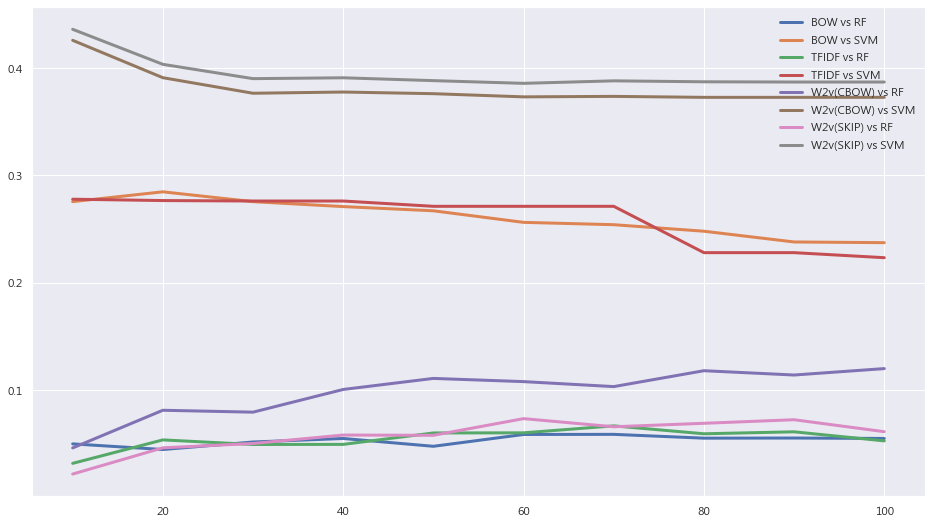

In [63]:
answer = pd.read_csv("iceland_result_f1.csv",index_col=0)
plt.figure(figsize=(16,9))

for i in range(len(answer.columns)):
    plt.plot(weight,answer.iloc[:,i],label="{}".format(answer.columns[i]),lw=3)

plt.rc('legend', fontsize=15)
plt.legend(loc=1)
plt.show()

### 冰島最終模型比較

#### BOW

In [155]:
Bag_of_word(iceland,"rf","auc_score",10,we=90)

0.8496147553205181

In [156]:
Bag_of_word(iceland,"svm","auc_score",10,we=70)

0.8704333602248226

In [157]:
Bag_of_word(iceland,"gb","auc_score",10,lr=0.1)

0.8956787143562569

#### TFIDF

In [158]:
tf_idf(iceland,"rf","auc_score",10,we=90)

0.8727942789726505

In [161]:
tf_idf(iceland,"svm","auc_score",10,we=80)

0.9073519215320325

In [163]:
tf_idf(iceland,"gb","auc_score",10,lr=0.1)

0.8952248850403003

#### CBOW

In [164]:
w2v("rf",c_word,c_y,"auc_score",10,we=100)

0.822720012349496

In [165]:
w2v("svm",c_word,c_y,"auc_score",10,we=40)

0.938257819319646

In [17]:
w2v("gb",c_word,c_y,"auc_score",10,lr=0.1)

0.9252310566537613

#### SKIP

In [166]:
w2v("rf",s_word,s_y,"auc_score",10,we=100)

0.7880705838197415

In [167]:
w2v("svm",s_word,s_y,"auc_score",10,we=70)

0.9399646833075329

In [15]:
w2v("gb",s_word,s_y,"auc_score",10,lr=0.1)

0.9373643768692386

#### ROC

In [107]:
fpr1, tpr1, thresholds_keras = Bag_of_word(iceland,"rf","roc",10,we=90)
fpr4, tpr4, thresholds_keras = tf_idf(iceland,"rf","roc",10,we=90)
fpr7, tpr7, thresholds_keras = w2v("rf",c_word,c_y,"roc",10,we=100)
fpr10, tpr10, thresholds_keras = w2v("rf",s_word,s_y,"roc",10,we=100)

In [108]:
fpr2, tpr2, thresholds_keras = Bag_of_word(iceland,"svm","roc",10,we=70)
fpr5, tpr5, thresholds_keras = tf_idf(iceland,"svm","roc",10,we=80)
fpr8, tpr8, thresholds_keras = w2v("svm",c_word,c_y,"roc",10,we=40)
fpr11, tpr11, thresholds_keras = w2v("svm",s_word,s_y,"roc",10,we=70)

In [60]:
fpr3, tpr3, thresholds_keras = Bag_of_word(iceland,"gb","roc",10,lr=0.1)
fpr6, tpr6, thresholds_keras = tf_idf(iceland,"gb","roc",10,lr=0.1)
fpr9, tpr9, thresholds_keras = w2v("gb",c_word,c_y,"roc",10,lr=0.1)
fpr12, tpr12, thresholds_keras = w2v("gb",s_word,s_y,"roc",10,lr=0.1)

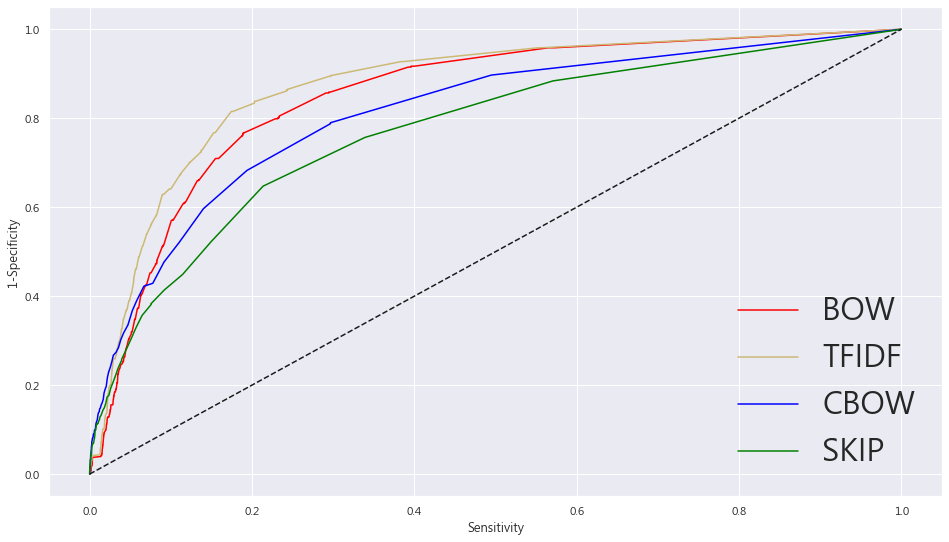

In [111]:
plt.figure(figsize=(16,9))

plt.plot(fpr1, tpr1, color='red', label='BOW')
plt.plot(fpr4, tpr4, color='y', label='TFIDF')
plt.plot(fpr7, tpr7, color='blue', label='CBOW')
plt.plot(fpr10, tpr10, color='green', label='SKIP')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')

plt.rc('legend', fontsize=30)
plt.legend(loc=4)
plt.show()

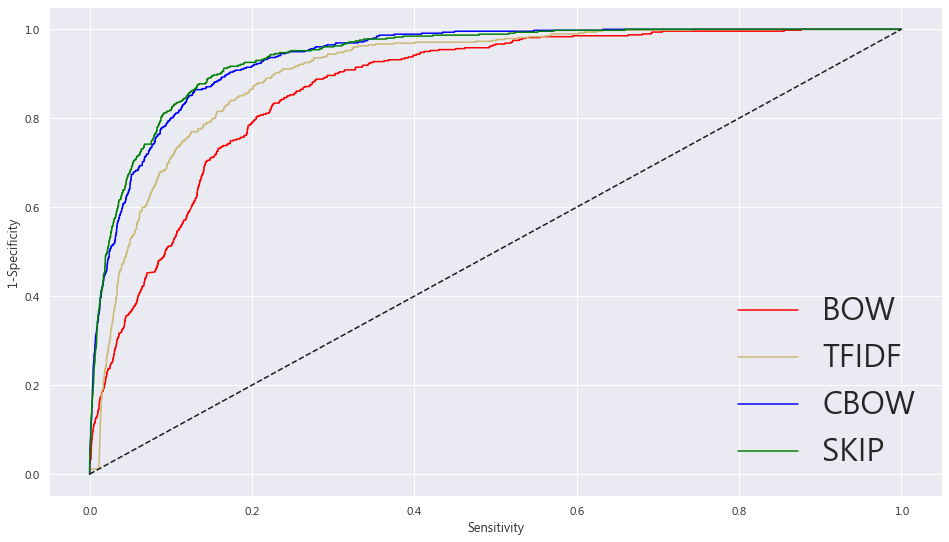

In [112]:
plt.figure(figsize=(16,9))

plt.plot(fpr2, tpr2, color='red', label='BOW')
plt.plot(fpr5, tpr5, color='y', label='TFIDF')
plt.plot(fpr8, tpr8, color='blue', label='CBOW')
plt.plot(fpr11, tpr11, color='green', label='SKIP')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')

plt.rc('legend', fontsize=30)
plt.legend(loc=4)
plt.show()

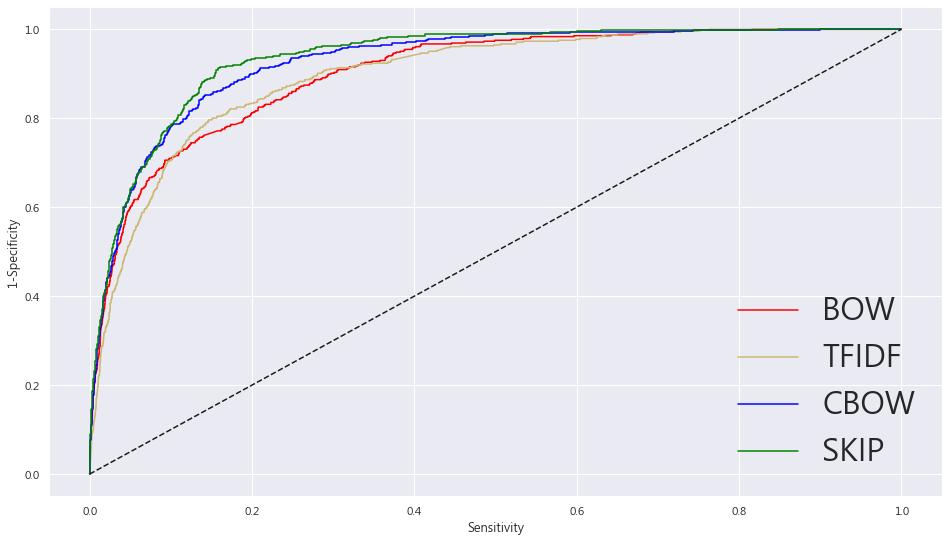

In [79]:
plt.figure(figsize=(16,9))

plt.plot(fpr3, tpr3, color='red', label='BOW')
plt.plot(fpr6, tpr6, color='y', label='TFIDF')
plt.plot(fpr9, tpr9, color='blue', label='CBOW')
plt.plot(fpr12, tpr12, color='green', label='SKIP')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')

plt.rc('legend', fontsize=30)
plt.legend(loc=4)
plt.show()

# 希臘

In [30]:
greece["reviews_clear"] = greece["reviews_clear"].apply(lambda x : np.str(x))

In [31]:
#initial

token_re = RegexpTokenizer(r'[a-zA-Z0-9]+')

weight = [(i+1)*10 for i in range(10)]

model_type = {"rf":1,"svm":2,"gb":3}

word2v_type ={"cbow":0,"skip":1}

### 詞袋

In [9]:
recall_bow_rf = []
for i in weight :
    recall_bow_rf.append(Bag_of_word(greece,"rf","recall",10,we=i))

recall_bow_rf

[0.043209876543209874,
 0.047325102880658436,
 0.053497942386831275,
 0.059670781893004114,
 0.053497942386831275,
 0.051440329218107,
 0.053497942386831275,
 0.06172839506172839,
 0.06172839506172839,
 0.06584362139917696]

In [66]:
f1_bow_rf = []
for i in weight :
    f1_bow_rf.append(Bag_of_word(greece,"rf","f1_score",10,we=i))
    
f1_bow_rf

[0.07749077490774908,
 0.08098591549295775,
 0.09027777777777778,
 0.09715242881072025,
 0.08695652173913045,
 0.08347245409015025,
 0.085667215815486,
 0.09538950715421303,
 0.09419152276295134,
 0.10000000000000002]

In [11]:
recall_bow_svm = []
for i in weight :
    recall_bow_svm.append(Bag_of_word(greece,"svm","recall",10,we=i))

recall_bow_svm

[0.3230452674897119,
 0.345679012345679,
 0.36419753086419754,
 0.37448559670781895,
 0.3765432098765432,
 0.3765432098765432,
 0.3786008230452675,
 0.3786008230452675,
 0.3786008230452675,
 0.38271604938271603]

In [67]:
f1_bow_svm = []
for i in weight :
    f1_bow_svm.append(Bag_of_word(greece,"svm","f1_score",10,we=i))

f1_bow_svm

[0.35722411831626844,
 0.3278048780487805,
 0.31466666666666665,
 0.30665543386689126,
 0.3007395234182416,
 0.2930344275420336,
 0.28549262994569435,
 0.27710843373493976,
 0.27078734363502577,
 0.23739629865985962]

In [12]:
recall_bow_gb = Bag_of_word(greece,"gb","recall",10,lr=0.1)
recall_bow_gb

0.19135802469135801

In [68]:
f1_bow_gb = Bag_of_word(greece,"gb","f1_score",10,lr=0.1)
f1_bow_gb

0.2835365853658537

### TF-IDF

In [13]:
recall_tf_rf = []
for i in weight :
    recall_tf_rf.append(tf_idf(greece,"rf","recall",10,we=i))

recall_tf_rf

[0.018518518518518517,
 0.03292181069958848,
 0.03497942386831276,
 0.037037037037037035,
 0.0411522633744856,
 0.04526748971193416,
 0.05555555555555555,
 0.053497942386831275,
 0.053497942386831275,
 0.07407407407407407]

In [69]:
f1_tf_rf = []
for i in weight :
    f1_tf_rf.append(tf_idf(greece,"rf","f1_score",10,we=i))

f1_tf_rf

[0.03508771929824561,
 0.0595903165735568,
 0.06273062730627306,
 0.06440071556350627,
 0.07054673721340389,
 0.07719298245614035,
 0.0923076923076923,
 0.08934707903780069,
 0.08469055374592833,
 0.11538461538461538]

In [14]:
recall_tf_svm = []
for i in weight :
    recall_tf_svm.append(tf_idf(greece,"svm","recall",10,we=i))

recall_tf_svm

[0.23868312757201646,
 0.23868312757201646,
 0.24074074074074073,
 0.23868312757201646,
 0.23868312757201646,
 0.23868312757201646,
 0.23868312757201646,
 0.23868312757201646,
 0.23868312757201646,
 0.23868312757201646]

In [70]:
f1_tf_svm = []
for i in weight :
    f1_tf_svm.append(tf_idf(greece,"svm","f1_score",10,we=i))

f1_tf_svm

[0.32584269662921345,
 0.3173734610123119,
 0.3124165554072096,
 0.30606860158311344,
 0.30526315789473685,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963]

In [15]:
recall_tf_gb = tf_idf(greece,"gb","recall",10,lr=0.1)
recall_tf_gb

0.12962962962962962

In [71]:
f1_tf_gb = tf_idf(greece,"gb","f1_score",10,lr=0.1)
f1_tf_gb

0.19504643962848298

### W2V

In [63]:
word2v = greece.translate_reviews.apply(word_tokenize)
word2v = word2v.apply(lambda x : [i.lower() for i in x])

In [ ]:
model_cbow = Word2Vec(word2v,
                      min_count=5,
                      vector_size=1000,
                      workers=10,
                      epochs=100,
                      window=5,
                      sg=0, # CBOW
                      seed=10,
                      batch_words=500)

model_skip = Word2Vec(word2v,
                      min_count=5,
                      vector_size=1000,
                      workers=10,
                      epochs=100,
                      window=5,
                      sg=1, # Skip-gram
                      seed=10,
                      batch_words=500)

def average_vector(review,type):
    
    tp = word2v_type[type]

    if tp == 0:
        
        array=np.array([model_cbow.wv[w] for w in review if w in model_cbow.wv])
    
        return pd.Series(array.mean(axis=0)) 

    elif tp == 1:
        
        array=np.array([model_skip.wv[w] for w in review if w in model_skip.wv])
    
        return pd.Series(array.mean(axis=0)) 

In [64]:
model_cbow = Word2Vec.load('cbow_greece.model')
model_skip = Word2Vec.load('skip_greece.model')

In [ ]:
def average_vector(review,type):
    
    tp = word2v_type[type]

    if tp == 0:
        
        array=np.array([model_cbow.wv[w] for w in review if w in model_cbow.wv])
    
        return pd.Series(array.mean(axis=0)) 

    elif tp == 1:
        
        array=np.array([model_skip.wv[w] for w in review if w in model_skip.wv])
    
        return pd.Series(array.mean(axis=0)) 

In [66]:
av_word_c = word2v.apply(lambda x :average_vector(x,"cbow"))
c_word = av_word_c.dropna(axis=0,how="any")
c_y = greece["sentiment"][c_word.index]

av_word_s = word2v.apply(lambda x :average_vector(x,"skip"))
s_word = av_word_s.dropna(axis=0,how="any")
s_y = greece["sentiment"][s_word.index]

<ipython-input-57-23c38493368a>:29: RuntimeWarning: Mean of empty slice.
  return pd.Series(array.mean(axis=0))
<ipython-input-57-23c38493368a>:35: RuntimeWarning: Mean of empty slice.
  return pd.Series(array.mean(axis=0))


In [51]:
model_cbow.save("cbow_greece.model")
model_skip.save("skip_greece.model")

In [21]:
recall_w2v_cbow_rf = []
for i in weight :
    recall_w2v_cbow_rf.append(w2v("rf",c_word,c_y,"recall",10,we=i))

recall_w2v_cbow_rf

[0.01293103448275862,
 0.02586206896551724,
 0.023706896551724137,
 0.034482758620689655,
 0.032327586206896554,
 0.040948275862068964,
 0.028017241379310345,
 0.034482758620689655,
 0.03879310344827586,
 0.036637931034482756]

In [20]:
f1_w2v_cbow_rf = []
for i in weight :
    f1_w2v_cbow_rf.append(w2v("rf",c_word,c_y,"f1_score",10,we=i))

f1_w2v_cbow_rf

[0.029288702928870296,
 0.04106776180698152,
 0.03719008264462809,
 0.045081967213114756,
 0.05691056910569106,
 0.06477732793522267,
 0.06122448979591837,
 0.06072874493927126,
 0.0489795918367347,
 0.048879837067209775]

In [40]:
recall_w2v_cbow_svm = []
for i in weight :
    recall_w2v_cbow_svm.append(w2v("svm",c_word,c_y,"recall",10,we=i))

recall_w2v_cbow_svm

[0.6099137931034483,
 0.6681034482758621,
 0.6745689655172413,
 0.6767241379310345,
 0.6810344827586207,
 0.6767241379310345,
 0.6767241379310345,
 0.6788793103448276,
 0.6788793103448276,
 0.6788793103448276]

In [18]:
f1_w2v_cbow_svm = []
for i in weight :
    f1_w2v_cbow_svm.append(w2v("svm",c_word,c_y,"f1_score",10,we=i))

f1_w2v_cbow_svm

[0.40905770635500366,
 0.3836990595611285,
 0.3713942307692307,
 0.37234042553191493,
 0.3698069046225863,
 0.36799065420560745,
 0.3689433741973146,
 0.367561260210035,
 0.367561260210035,
 0.367561260210035]

In [41]:
recall_w2v_cbow_gb = w2v("gb",c_word,c_y,"recall",10,lr=0.1)
recall_w2v_cbow_gb

In [43]:
recall_w2v_cbow_gb

0.125

In [44]:
f1_w2v_cbow_gb = w2v("gb",c_word,c_y,"f1_score",10,lr=0.1)
f1_w2v_cbow_gb

0.2038664323374341

In [41]:
recall_w2v_skip_rf = []
for i in weight :
    recall_w2v_skip_rf.append(w2v("rf",s_word,s_y,"recall",10,we=i))

recall_w2v_skip_rf

[0.01293103448275862,
 0.015086206896551725,
 0.01293103448275862,
 0.01939655172413793,
 0.015086206896551725,
 0.01293103448275862,
 0.021551724137931036,
 0.021551724137931036,
 0.023706896551724137,
 0.021551724137931036]

In [19]:
f1_w2v_skip_rf = []
for i in weight :
    f1_w2v_skip_rf.append(w2v("rf",s_word,s_y,"f1_score",10,we=i))

f1_w2v_skip_rf

[0.01702127659574468,
 0.03773584905660378,
 0.03781512605042017,
 0.04573804573804574,
 0.033542976939203356,
 0.04158004158004158,
 0.03333333333333333,
 0.03333333333333333,
 0.03347280334728033,
 0.03757828810020877]

In [42]:
recall_w2v_skip_svm = []
for i in weight :
    recall_w2v_skip_svm.append(w2v("svm",s_word,s_y,"recall",10,we=i))

recall_w2v_skip_svm

[0.6185344827586207,
 0.6810344827586207,
 0.6853448275862069,
 0.6961206896551724,
 0.6961206896551724,
 0.6982758620689655,
 0.6982758620689655,
 0.6982758620689655,
 0.6982758620689655,
 0.6982758620689655]

In [28]:
f1_w2v_skip_svm = []
for i in weight :
    f1_w2v_skip_svm.append(w2v("svm",s_word,s_y,"f1_score",10,we=i))

f1_w2v_skip_svm

[0.40769779044903776,
 0.3725961538461539,
 0.36394948335246846,
 0.36363636363636365,
 0.35984207557811615,
 0.35874439461883406,
 0.3576233183856502,
 0.3570229434806939,
 0.35662381218557854,
 0.35662381218557854]

In [45]:
recall_w2v_skip_gb = w2v("gb",s_word,s_y,"recall",10,lr=0.1)
recall_w2v_skip_gb 

0.1314655172413793

In [46]:
f1_w2v_skip_gb = w2v("gb",s_word,s_y,"f1_score",10,lr=0.1)
f1_w2v_skip_gb

0.21746880570409982

### result

In [43]:
### 結果儲存
answer = pd.DataFrame({"BOW vs RF":recall_bow_rf,
                       "BOW vs SVM":recall_bow_svm,
                       "TFIDF vs RF":recall_tf_rf,
                       "TFIDF vs SVM":recall_tf_svm,
                       "W2v(CBOW) vs RF":recall_w2v_cbow_rf,
                       "W2v(CBOW) vs SVM":recall_w2v_cbow_svm,
                       "W2v(SKIP) vs RF":recall_w2v_skip_rf,
                       "W2v(SKIP) vs SVM":recall_w2v_skip_svm})

answer.index = [weight]

answer.to_csv("greece_result.csv")

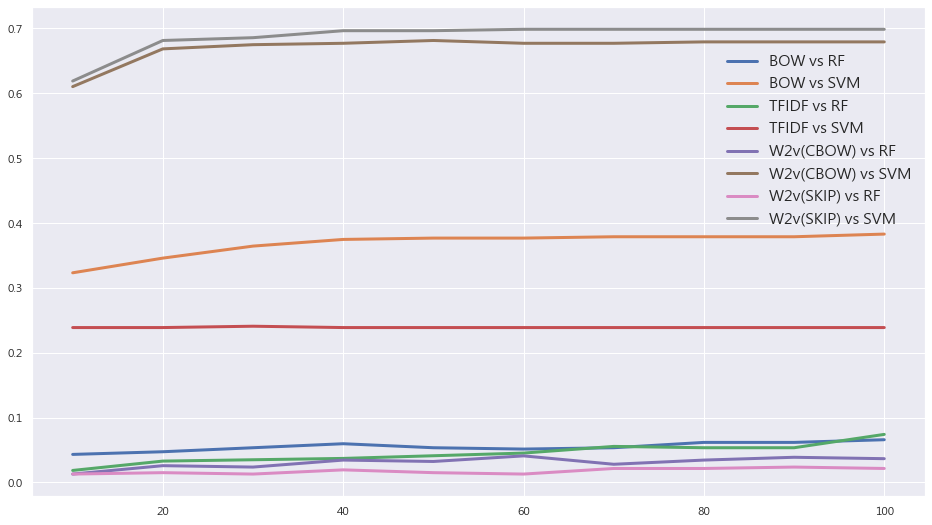

In [75]:
answer = pd.read_csv("greece_result.csv",index_col=0)
plt.figure(figsize=(16,9))

for i in range(len(answer.columns)):
    plt.plot(weight,answer.iloc[:,i],label="{}".format(answer.columns[i]),lw=3)

plt.rc('legend', fontsize=15)
plt.legend(loc=1,bbox_to_anchor=(1,0.93))
plt.show()

In [ ]:
answer1 = pd.DataFrame({"BOW vs RF":f1_bow_rf,
                       "BOW vs SVM":f1_bow_svm,
                       "TFIDF vs RF":f1_tf_rf,
                       "TFIDF vs SVM":f1_tf_svm,
                       "W2v(CBOW) vs RF":f1_w2v_cbow_rf,
                       "W2v(CBOW) vs SVM":f1_w2v_cbow_svm,
                       "W2v(SKIP) vs RF":f1_w2v_skip_rf,
                       "W2v(SKIP) vs SVM":f1_w2v_skip_svm})

answer1.index = [weight]

answer1.to_csv("greece_result_f1.csv")

In [ ]:
answer = pd.read_csv("greece_result_f1.csv",index_col=0)
plt.figure(figsize=(16,9))

for i in range(len(answer.columns)):
    plt.plot(weight,answer.iloc[:,i],label="{}".format(answer.columns[i]),lw=3)

plt.rc('legend', fontsize=15)
plt.legend(loc=1)
plt.show()

### 希臘最終模型比較

In [29]:
Bag_of_word(greece,"rf","auc_score",10,we=100)

0.8565283697810347

In [30]:
Bag_of_word(greece,"svm","auc_score",10,we=100)

0.8579404223791047

In [33]:
Bag_of_word(greece,"gb","auc_score",10,lr=0.1)

0.9016843672562485

In [31]:
tf_idf(greece,"rf","auc_score",10,we=100)

0.8740585062010203

In [35]:
tf_idf(greece,"svm","auc_score",10,we=30)

0.9092667285551181

In [36]:
tf_idf(greece,"gb","auc_score",10,lr=0.1)

0.897606760998675

In [37]:
w2v("rf",c_word,c_y,"auc_score",10,we=60)

0.8485168909168374

In [38]:
w2v("svm",c_word,c_y,"auc_score",10,we=50)

0.9289138841549731

In [52]:
w2v("gb",c_word,c_y,"auc_score",10,lr=0.1)

0.9270051664582216

In [39]:
w2v("rf",s_word,s_y,"auc_score",10,we=90)

0.8053787972494423

In [40]:
w2v("svm",s_word,s_y,"auc_score",10,we=60)

0.9306467979641109

In [53]:
w2v("gb",s_word,s_y,"auc_score",10,lr=0.1)

0.930097768722255

In [67]:
fpr1, tpr1, thresholds_keras = Bag_of_word(greece,"rf","roc",10,we=100)
fpr4, tpr4, thresholds_keras = tf_idf(greece,"rf","roc",10,we=100)
fpr7, tpr7, thresholds_keras = w2v("rf",c_word,c_y,"roc",10,we=60)
fpr10, tpr10, thresholds_keras = w2v("rf",s_word,s_y,"roc",10,we=90)

In [68]:
fpr2, tpr2, thresholds_keras = Bag_of_word(greece,"svm","roc",10,we=100)
fpr5, tpr5, thresholds_keras = tf_idf(greece,"svm","roc",10,we=30)
fpr8, tpr8, thresholds_keras = w2v("svm",c_word,c_y,"roc",10,we=50)
fpr11, tpr11, thresholds_keras = w2v("svm",s_word,s_y,"roc",10,we=60)

In [92]:
fpr3, tpr3, thresholds_keras = Bag_of_word(greece,"gb","roc",10,lr=0.1)
fpr6, tpr6, thresholds_keras = tf_idf(greece,"gb","roc",10,lr=0.1)
fpr9, tpr9, thresholds_keras = w2v("gb",c_word,c_y,"roc",10,lr=0.1)
fpr12, tpr12, thresholds_keras = w2v("gb",s_word,s_y,"roc",10,lr=0.1)

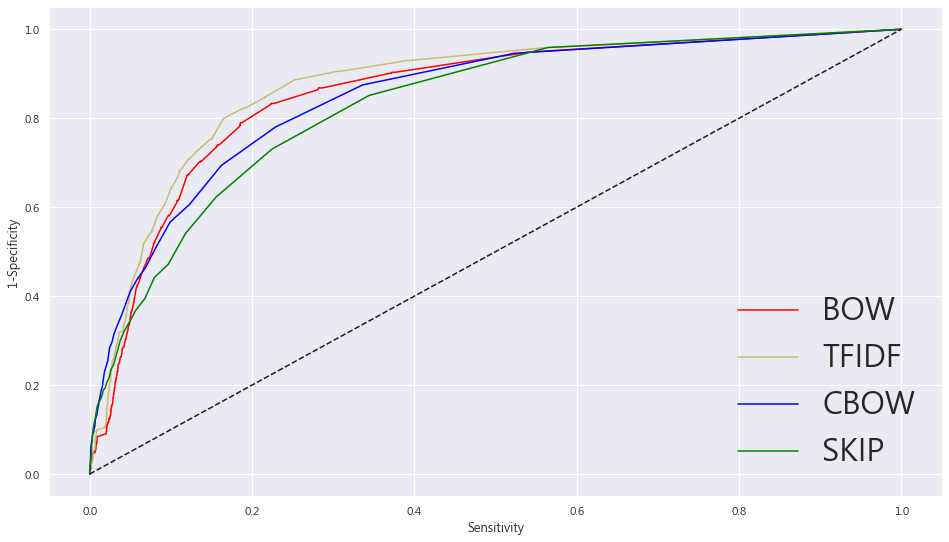

In [99]:
plt.figure(figsize=(16,9))

plt.plot(fpr1, tpr1, color='red', label='BOW')
plt.plot(fpr4, tpr4, color='y', label='TFIDF')
plt.plot(fpr7, tpr7, color='blue', label='CBOW')
plt.plot(fpr10, tpr10, color='green', label='SKIP')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')

plt.rc('legend', fontsize=30)
plt.legend(loc=4)
plt.show()

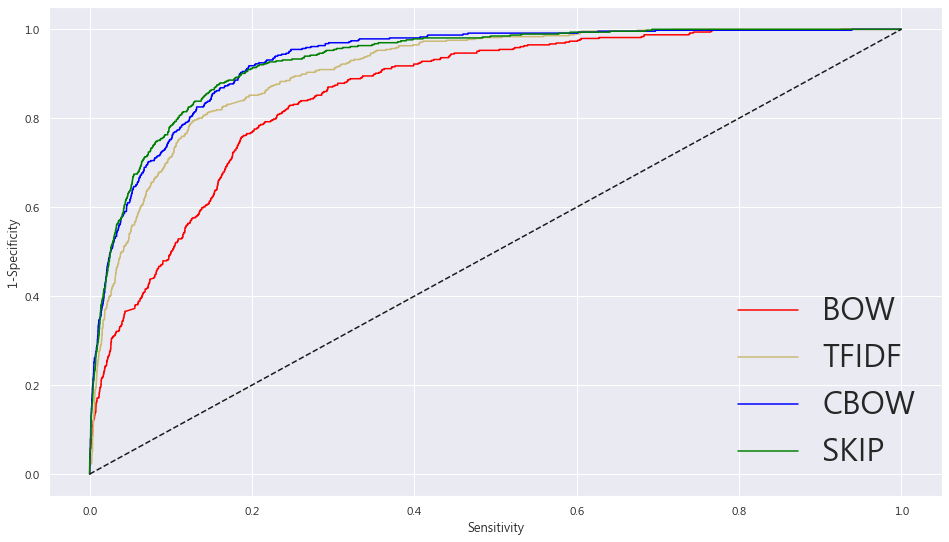

In [98]:
plt.figure(figsize=(16,9))

plt.plot(fpr2, tpr2, color='red', label='BOW')
plt.plot(fpr5, tpr5, color='y', label='TFIDF')
plt.plot(fpr8, tpr8, color='blue', label='CBOW')
plt.plot(fpr11, tpr11, color='green', label='SKIP')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')

plt.rc('legend', fontsize=30)
plt.legend(loc=4)
plt.show()

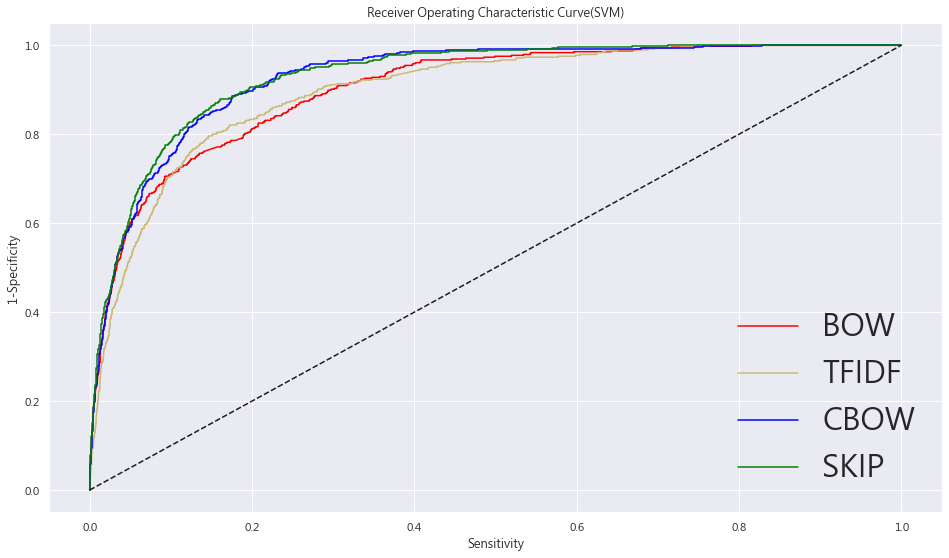

In [97]:
plt.figure(figsize=(16,9))

plt.plot(fpr3, tpr3, color='red', label='BOW')
plt.plot(fpr6, tpr6, color='y', label='TFIDF')
plt.plot(fpr9, tpr9, color='blue', label='CBOW')
plt.plot(fpr12, tpr12, color='green', label='SKIP')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')
plt.title('Receiver Operating Characteristic Curve(SVM)')

plt.rc('legend', fontsize=30)
plt.legend(loc=4)
plt.show()

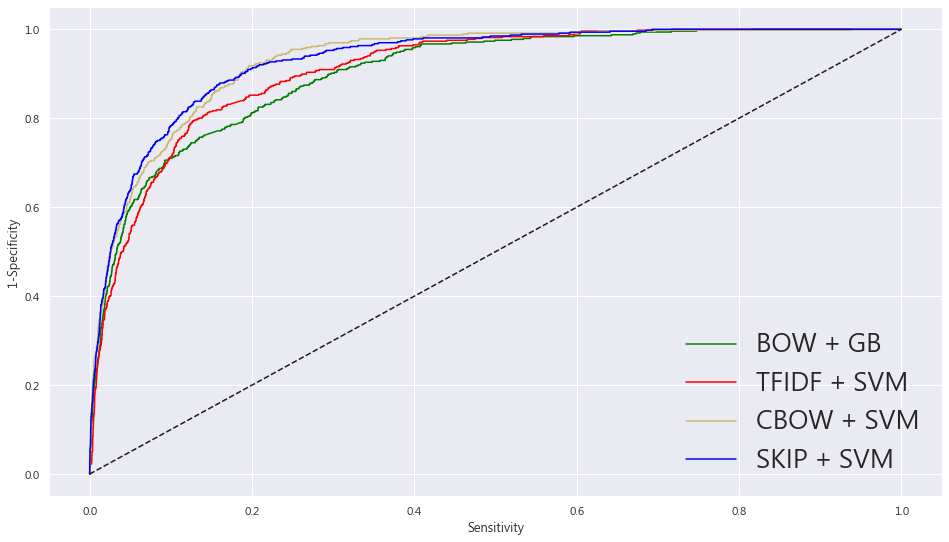

In [95]:
plt.figure(figsize=(16,9))

plt.plot(fpr3, tpr3, color='green', label='BOW + GB')
plt.plot(fpr5, tpr5, color='red', label='TFIDF + SVM')
plt.plot(fpr8, tpr8, color='y', label='CBOW + SVM')
plt.plot(fpr11, tpr11, color='blue', label='SKIP + SVM')
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlabel('Sensitivity')
plt.ylabel('1-Specificity')

plt.rc('legend', fontsize=25)
plt.legend(loc=4)
plt.show()